In [1]:
# main libraries
import pandas as pd
import numpy as np

# visual libraries
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# sklearn libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report,roc_curve
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


E:\Anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Data Exploration and Pre-Processing

In [2]:
df = pd.read_csv("D:\Important\Minor Project\Epileptic Seizure Recognition.csv")
df.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [3]:
#df.shape

In [4]:
#Check if there are any missing values
df.isnull().values.any()

False

In [5]:
#Creating new column "SEIZURE_OUTPUT" that shows 1 for seizure and 0 for non Seizure activity
df["SEIZURE_OUTPUT"] = df.y == 1
df["SEIZURE_OUTPUT"] = df["SEIZURE_OUTPUT"].astype(int)
df.pop('y')
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,SEIZURE_OUTPUT
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [6]:
#This function calculates the prevalence of the positive class (label = 1)
#Prevalence_rate is the proportion of seizure cases in the whole dataset
def calc_prevalence(y_actual):
    
    return sum(y_actual) / len(y_actual)


print(
    "prevalence_rate of the dataset: %.3f"
    % calc_prevalence(df["SEIZURE_OUTPUT"].values)
)

prevalence_rate of the dataset: 0.200


# Feature Engineering

In [7]:
#Creating a new dataframe which has only the columns of interest from our original dataset. 
#This is done so that building our testing, validation and training data sets becomes easier.

collist = df.columns.tolist()
cols_input = collist[0:178]
df2 = df[cols_input + ["SEIZURE_OUTPUT"]]

In [8]:
#Check for duplicated columns in cols_input
dup_cols = set([x for x in cols_input if cols_input.count(x) > 1])
print(dup_cols)
assert len(dup_cols) == 0, "you have duplicated columns in cols_input"

set()


In [9]:
#Check for duplicated columns in df2
cols_df_data = list(df2.columns)
dup_cols = set([x for x in cols_df_data if cols_df_data.count(x) > 1])
print(dup_cols)
assert len(dup_cols) == 0,'you have duplicated columns in df2'

set()


In [10]:
#Check the size of df_data makes sense
assert (len(cols_input) + 1) == len(
    df2.columns
), "issue with dimensions of df2 or cols_input"

# Building Training/Validation/Testing sets

In [11]:
#Now we begin spiltting up our dataset into training, validation and testing data sets. 
#The training split is used to train our machine learning algorithm, hence why we would want to use the majority of our dataset.
#The validation dataset is use to tune hyperparameters and to select the best performing approach. 
#The testing dataset is used to test the accuracy of our machine learning model.

In [12]:
#Shuffle our dataset to make sure that there isn’t some order associated with our samples.
df2 = df2.sample(n=len(df2))
df2 = df2.reset_index(drop=True)

In [13]:
#df2.shape

In [14]:
#Taking training/validation/test data sets in 70/15/15 ratio
df_valid_test = df2.sample(frac=0.3)           #Contains 30% sample of df2
print("Validation/Test Split Size: %.1f" % (len(df_valid_test) / len(df2)))

df_test = df_valid_test.sample(frac=0.5)       #Test dataset contains 50% sample of valid_test 
df_valid = df_valid_test.drop(df_test.index)   

df_train_all = df2.drop(df_valid_test.index)

Validation/Test Split Size: 0.3


In [15]:
df_valid_test.shape

(3451, 179)

In [16]:
df_valid.shape

(1725, 179)

In [17]:
df_test.shape

(1726, 179)

In [18]:
df_train_all.shape

(8052, 179)

In [19]:
#Check the prevalence_rate of each data set.
#If prevalence_rate of all 3 datasets is approximately the same, then that means that the data is evenly distributed. 
print(
    "Test prevalence_rate(n = %d):%.3f"
    % (len(df_test), calc_prevalence(df_test.SEIZURE_OUTPUT.values))
)
print(
    "Valid prevalence_rate(n = %d):%.3f"
    % (len(df_valid), calc_prevalence(df_valid.SEIZURE_OUTPUT.values))
)
print(
    "Train all prevalence_rate(n = %d):%.3f"
    % (len(df_train_all), calc_prevalence(df_train_all.SEIZURE_OUTPUT.values))
)

Test prevalence_rate(n = 1726):0.211
Valid prevalence_rate(n = 1725):0.210
Train all prevalence_rate(n = 8052):0.196


In [20]:
#Check if there are no missing values/features/samples again
print('all samples (n = %d)'%len(df2))
assert len(df2) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 11503)


In [21]:
#Our training data set has a prevalance rate 20% which means that there are many more negative samples than positive ones.
#This is not desirable as we want our model to be trained without bias.
#To rectify this, we use the sub-sample balancing method to achieve a prevalence_rate of 50% which will be unbiased data set.

In [22]:
rows_pos = df_train_all.SEIZURE_OUTPUT == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

n = np.min([len(df_train_pos), len(df_train_neg)])

df_train = pd.concat([df_train_pos.sample(n=n, random_state=69), df_train_neg.sample(n=n, random_state=69)], axis=0, ignore_index=True)

df_train = df_train.sample(n=len(df_train), random_state=69).reset_index(drop=True)

print('Training_set balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.SEIZURE_OUTPUT.values)))

Training_set balanced prevalence(n = 3150):0.500


In [23]:
df_train.shape

(3150, 179)

In [24]:
#Save all 4 dataframes to a csv
df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

In [25]:
#Create X and Y matrices from our training set to measure the results of the model
X_train = df_train[cols_input].values
X_train_all = df_train_all[cols_input].values
X_valid = df_valid[cols_input].values

y_train = df_train['SEIZURE_OUTPUT'].values
y_valid = df_valid['SEIZURE_OUTPUT'].values

X_test = df_test[cols_input].values
y_test = df_test['SEIZURE_OUTPUT'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (8052, 178)
Training shapes: (3150, 178) (3150,)
Validation shapes: (1725, 178) (1725,)


In [26]:
type(y_train)

numpy.ndarray

In [27]:
y_train

array([1, 1, 1, ..., 0, 0, 0])

In [28]:
X_test

array([[ -11,  -17,  -20, ...,  -15,  -21,  -26],
       [-132, -137, -137, ...,    8,   -1,  -22],
       [   3,  -44,  -80, ...,  -86,  -52,  -28],
       ...,
       [  44,   39,   38, ...,  -22,  -18,  -22],
       [ 274,  320,  348, ..., -219, -493, -735],
       [ 151,  164,  184, ...,  -67,  -60,  -57]], dtype=int64)

In [29]:
#Normalize the data and pickle it using StandardScaler and pickle library.
import pickle

scaler  = StandardScaler()
scaler.fit(X_train_all)

scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))
scaler = pickle.load(open(scalerfile, 'rb'))

#y_train=np.array(y_test).reshape(-1,1)

#Transform our data matrices so that data will have a mean value 0 and standard deviation of 1.
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)
X_test_tf = scaler.transform(X_test)
#y_train_tf = scaler.transform(y_train)

In [30]:
X_test_tf

array([[ 2.98901151e-03, -3.98662172e-02, -6.65164473e-02, ...,
        -2.77905390e-02, -6.64100599e-02, -9.78919311e-02],
       [-7.32036229e-01, -7.68052642e-01, -7.80791684e-01, ...,
         1.16265683e-01,  5.81349039e-02, -7.32748749e-02],
       [ 8.80332542e-02, -2.03708163e-01, -4.32811440e-01, ...,
        -4.72485834e-01, -2.59454754e-01, -1.10200459e-01],
       ...,
       [ 3.37091394e-01,  2.99954114e-01,  2.87568713e-01, ...,
        -7.16337371e-02, -4.77283153e-02, -7.32748749e-02],
       [ 1.73424681e+00,  2.00512399e+00,  2.18009284e+00, ...,
        -1.30550660e+00, -3.00567121e+00, -4.46126513e+00],
       [ 9.87072392e-01,  1.05848164e+00,  1.17888653e+00, ...,
        -3.53482868e-01, -3.09272739e-01, -2.88674116e-01]])

In [31]:
df2.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,SEIZURE_OUTPUT
0,-38,-18,-7,-2,20,12,-12,-8,15,15,...,-22,-13,4,-1,1,13,7,-1,10,0
1,207,0,-182,-225,-142,51,250,398,515,523,...,153,-466,-1088,-1359,-1206,-750,-284,101,341,1
2,45,46,48,56,62,65,61,58,57,48,...,-20,-26,-30,-32,-32,-33,-34,-35,-32,0
3,75,70,71,67,74,89,102,110,111,113,...,29,11,1,7,26,45,58,60,49,0
4,41,48,50,57,65,58,44,33,23,8,...,-5,4,-1,2,18,42,37,24,15,0


# Code Blocks to calculate parameters

In [32]:
def print_report(tn,fp,fn,tp,p,n):
    import math
    accuracy = ((tp + tn)/(tp + tn + fp + fn))*100
    precision = tp/(fp + tp)
    recall = tp/(fn + tp)
    f1_measure = 2*(precision*recall)/(precision+recall)
    sensitivity = tp/p
    specificity = tn/n
    mcc = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    
    print('Accuracy:%.3f'%accuracy,"%")
    print('Precision:%.3f'%precision)
    print('Recall:%.3f'%recall)
    print('F1-score:%.3f'%f1_measure)
    #print('Sensitivity:%.3f'%sensitivity)
    print('Specificity:%.3f'%specificity)
    print('Matthews correlation coefficient:%.3f'%mcc)
    
    return accuracy, precision, recall, f1_measure, sensitivity, specificity, mcc

In [33]:
def cm_results(title, cm, test, pred):
    
    LABELS = ['Normal', 'Seizure']
    plt.figure(figsize=(7, 7))
    sns.heatmap(cm/np.sum(cm), annot=True ,cmap="binary")
    
    plt.title('\nConfusion matrix: {}'.format(title)+"\n")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    
    tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
    sum_ = tn+fp+fn+tp
    
    tn_per = round(tn/sum_*100,2)
    fp_per = round(fp/sum_*100,2)
    fn_per = round(fn/sum_*100,2)
    tp_per = round(tp/sum_*100,2)
    
    print("True Negatives: ",tn," True Negatives %: ",tn_per)
    print("False Positives: ",fp," False Postitves %: ",fp_per)
    print("False Negatives: ",fn," Flase Negatives %: ",fn_per)
    print("True Positives: ",tp," True Positives %: ",tp_per)
    

# Model Training

### KNN model

KNN MODEL-


Training Dataset:
Accuracy:82.921 %
Precision:0.998
Recall:0.660
F1-score:0.794
Sensitivity:0.660
Specificity:0.999
Matthews correlation coefficient:0.700


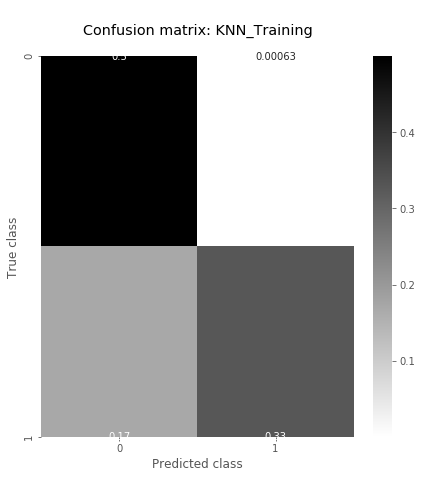

True Negatives:  1573  True Negatives %:  49.94
False Positives:  2  False Postitves %:  0.06
False Negatives:  536  Flase Negatives %:  17.02
True Positives:  1039  True Positives %:  32.98



Validation Dataset:
Accuracy:85.449 %
Precision:0.983
Recall:0.314
F1-score:0.476
Sensitivity:0.314
Specificity:0.999
Matthews correlation coefficient:0.509


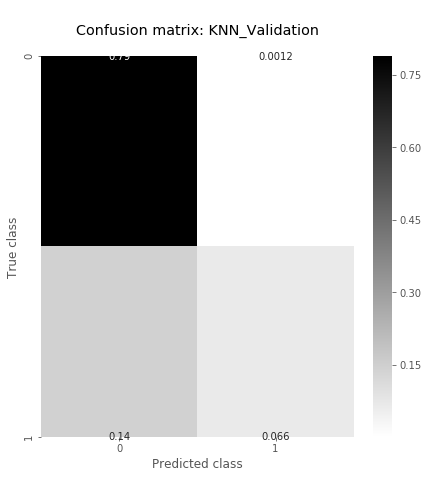

True Negatives:  1360  True Negatives %:  78.84
False Positives:  2  False Postitves %:  0.12
False Negatives:  249  Flase Negatives %:  14.43
True Positives:  114  True Positives %:  6.61


In [34]:
#Code that will calculate findings of KNN model

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier              #Importing KNN library
from sklearn.metrics import confusion_matrix

conf_matrix_model_KNN = ['KNN_Training','KNN_Validation']

knn_train = KNeighborsClassifier(n_neighbors = 10)              #Creating KNN classifier (k=10)
knn_valid = KNeighborsClassifier(n_neighbors = 10)              #Creating KNN classifier (k=10)
knn_train.fit(X_train_tf, y_train)                              #Fitting the model for our training data
knn_valid.fit(X_valid_tf, y_valid)                              #Fitting the model for our validation data

#Store the predicted output of the training feature set in variable 'y_train_pred'
y_train_pred = knn_train.predict(X_train_tf)
knn_train_cm = confusion_matrix(y_train,y_train_pred)           #Create confusion  matrix on training data

train_tn,train_fp,train_fn,train_tp = [(knn_train_cm[i,j]) for i in range(len(knn_train_cm)) for j in range(len(knn_train_cm))]
train_p = knn_train_cm[1,0] + knn_train_cm[1,1]
train_n = knn_train_cm[0,0] + knn_train_cm[0,1]


#Store the predicted output of the validation feature set in variable 'y_valid_pred'
y_valid_pred = knn_valid.predict(X_valid_tf)
knn_valid_cm = confusion_matrix(y_valid,y_valid_pred)           #Create confusion  matrix on validation data

valid_tn,valid_fp,valid_fn,valid_tp = [(knn_valid_cm[i,j]) for i in range(len(knn_valid_cm)) for j in range(len(knn_valid_cm))]
valid_p = knn_valid_cm[1,0] + knn_valid_cm[1,1]
valid_n = knn_valid_cm[0,0] + knn_valid_cm[0,1]

print('KNN MODEL-')
print("\n")
print('Training Dataset:')
knn_train_acc, knn_train_recall, knn_train_precision, knn_train_f1_measure, \
    knn_train_sensitivity, knn_train_specificity, knn_train_mcc = print_report(train_tn,train_fp,train_fn,train_tp,train_p,train_n)
cm_results(conf_matrix_model_KNN[0], knn_train_cm, y_train, y_train_pred)


print("\n\n")
print('Validation Dataset:')
knn_valid_acc, knn_valid_recall, knn_valid_precision, knn_valid_f1_measure, \
    knn_valid_sensitivity, knn_valid_specificity, knn_valid_mcc = print_report(valid_tn,valid_fp,valid_fn,valid_tp,valid_p,valid_n)
cm_results(conf_matrix_model_KNN[1], knn_valid_cm, y_valid, y_valid_pred)


### Logistic Regression Model

LOGISITIC REGRESSION MODEL-


Training Dataset:
Accuracy:65.429 %
Precision:0.711
Recall:0.520
F1-score:0.601
Sensitivity:0.520
Specificity:0.789
Matthews correlation coefficient:0.320


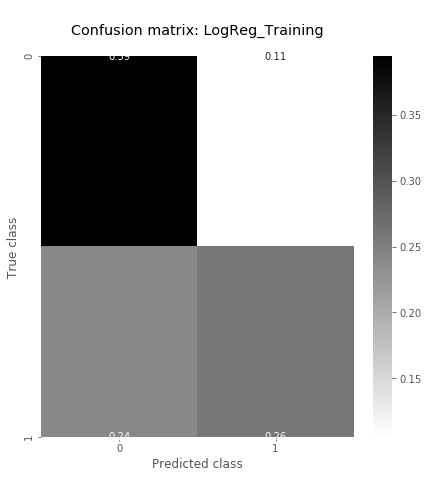

True Negatives:  1242  True Negatives %:  39.43
False Positives:  333  False Postitves %:  10.57
False Negatives:  756  Flase Negatives %:  24.0
True Positives:  819  True Positives %:  26.0



Validation Dataset:
Accuracy:86.087 %
Precision:0.962
Recall:0.353
F1-score:0.516
Sensitivity:0.353
Specificity:0.996
Matthews correlation coefficient:0.533


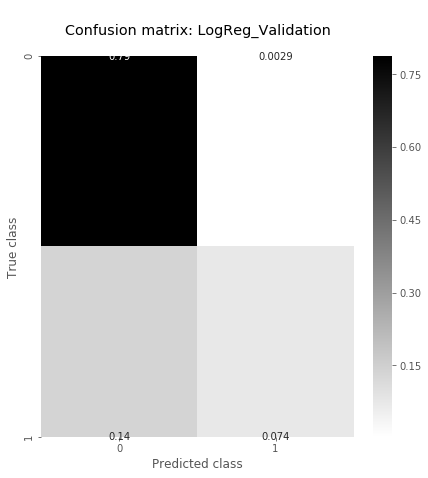

True Negatives:  1357  True Negatives %:  78.67
False Positives:  5  False Postitves %:  0.29
False Negatives:  235  Flase Negatives %:  13.62
True Positives:  128  True Positives %:  7.42


In [35]:
#Code that will calculate findings of Logistic Regression model

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression               #Import the Logistic Regression library 
from sklearn.metrics import confusion_matrix

conf_matrix_model_LR = ['LogReg_Training','LogReg_Validation']

lr_train = LogisticRegression(random_state = 69)                  #Create Logistic Regression Classifier for training data
lr_valid = LogisticRegression(random_state = 69)                  #Create Logistic Regression Classifier for validation data
lr_train.fit(X_train_tf, y_train)                                 #Fit classifier to our training sets
lr_valid.fit(X_valid_tf, y_valid)                                 #Fit classifier to our training sets

#Store the predicted output of the training feature set in variable 'y_train_pred'
y_train_pred = lr_train.predict(X_train_tf)
lr_train_cm = confusion_matrix(y_train,y_train_pred)              #Create confusion  matrix on training data

train_tn,train_fp,train_fn,train_tp = [(lr_train_cm[i,j]) for i in range(len(lr_train_cm)) for j in range(len(lr_train_cm))]
train_p = lr_train_cm[1,0] + lr_train_cm[1,1]
train_n = lr_train_cm[0,0] + lr_train_cm[0,1]


#Store the predicted output of the validation feature set in variable 'y_valid_pred'
y_valid_pred = lr_valid.predict(X_valid_tf)
lr_valid_cm = confusion_matrix(y_valid,y_valid_pred)              #Create confusion  matrix on validation data

valid_tn,valid_fp,valid_fn,valid_tp = [(lr_valid_cm[i,j]) for i in range(len(lr_valid_cm)) for j in range(len(lr_valid_cm))]
valid_p = lr_valid_cm[1,0] + lr_valid_cm[1,1]
valid_n = lr_valid_cm[0,0] + lr_valid_cm[0,1]

print('LOGISITIC REGRESSION MODEL-')
print("\n")
print('Training Dataset:')
lr_train_acc, lr_train_recall, lr_train_precision, lr_train_f1_measure, \
    lr_train_sensitivity, lr_train_specificity, lr_train_mcc = print_report(train_tn,train_fp,train_fn,train_tp,train_p,train_n)
cm_results(conf_matrix_model_LR[0], lr_train_cm, y_train, y_train_pred)

print("\n\n")
print('Validation Dataset:')
lr_valid_acc, lr_valid_recall, lr_valid_precision, lr_valid_f1_measure, \
    lr_valid_sensitivity, lr_valid_specificity, lr_valid_mcc = print_report(valid_tn,valid_fp,valid_fn,valid_tp,valid_p,valid_n)
cm_results(conf_matrix_model_LR[1], lr_valid_cm, y_valid, y_valid_pred)


### Naive Bayes Model

NAIVE BAYES MODEL-


Training Dataset:
Accuracy:93.429 %
Precision:0.971
Recall:0.895
F1-score:0.932
Sensitivity:0.895
Specificity:0.973
Matthews correlation coefficient:0.871


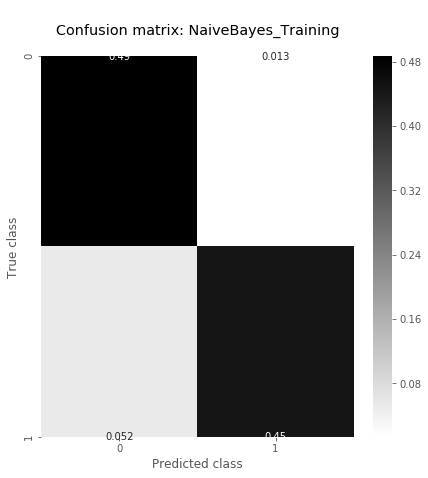

True Negatives:  1533  True Negatives %:  48.67
False Positives:  42  False Postitves %:  1.33
False Negatives:  165  Flase Negatives %:  5.24
True Positives:  1410  True Positives %:  44.76



Validation Dataset:
Accuracy:95.768 %
Precision:0.905
Recall:0.893
F1-score:0.899
Sensitivity:0.893
Specificity:0.975
Matthews correlation coefficient:0.872


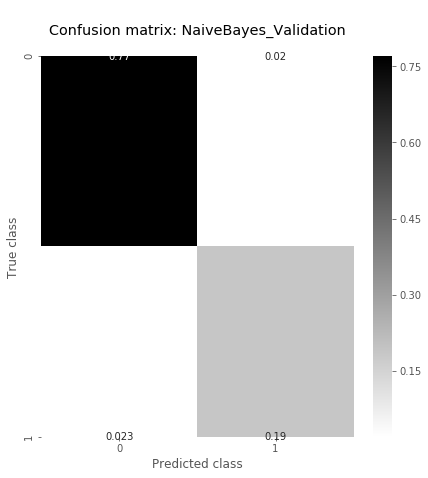

True Negatives:  1328  True Negatives %:  76.99
False Positives:  34  False Postitves %:  1.97
False Negatives:  39  Flase Negatives %:  2.26
True Positives:  324  True Positives %:  18.78


In [36]:
#Code that will calculate findings of Naive Bayes model

import warnings
warnings.filterwarnings('ignore')

from sklearn.naive_bayes import GaussianNB               #Import the Naive Bayes library 
from sklearn.metrics import confusion_matrix

conf_matrix_model_NB = ['NaiveBayes_Training','NaiveBayes_Validation']

nb_train = GaussianNB()                  #Create Logistic Regression Classifier for training data
nb_valid = GaussianNB()                  #Create Logistic Regression Classifier for validation data
nb_train.fit(X_train_tf, y_train)                                 #Fit classifier to our training sets
nb_valid.fit(X_valid_tf, y_valid)                                 #Fit classifier to our training sets

#Store the predicted output of the training feature set in variable 'y_train_pred'
y_train_pred = nb_train.predict(X_train_tf)
nb_train_cm = confusion_matrix(y_train,y_train_pred)              #Create confusion  matrix on training data

train_tn,train_fp,train_fn,train_tp = [(nb_train_cm[i,j]) for i in range(len(nb_train_cm)) for j in range(len(nb_train_cm))]
train_p = nb_train_cm[1,0] + nb_train_cm[1,1]
train_n = nb_train_cm[0,0] + nb_train_cm[0,1]


#Store the predicted output of the validation feature set in variable 'y_valid_pred'
y_valid_pred = nb_valid.predict(X_valid_tf)
nb_valid_cm = confusion_matrix(y_valid,y_valid_pred)              #Create confusion  matrix on validation data

valid_tn,valid_fp,valid_fn,valid_tp = [(nb_valid_cm[i,j]) for i in range(len(nb_valid_cm)) for j in range(len(nb_valid_cm))]
valid_p = nb_valid_cm[1,0] + nb_valid_cm[1,1]
valid_n = nb_valid_cm[0,0] + nb_valid_cm[0,1]

print('NAIVE BAYES MODEL-')
print("\n")
print('Training Dataset:')
nb_train_acc, nb_train_recall, nb_train_precision, nb_train_f1_measure, \
    nb_train_sensitivity, nb_train_specificity, nb_train_mcc = print_report(train_tn,train_fp,train_fn,train_tp,train_p,train_n)
cm_results(conf_matrix_model_NB[0], nb_train_cm, y_train, y_train_pred)

print("\n\n")
print('Validation Dataset:')
nb_valid_acc, nb_valid_recall, nb_valid_precision, nb_valid_f1_measure, \
    nb_valid_sensitivity, nb_valid_specificity, nb_valid_mcc = print_report(valid_tn,valid_fp,valid_fn,valid_tp,valid_p,valid_n)
cm_results(conf_matrix_model_NB[1], nb_valid_cm, y_valid, y_valid_pred)


### Random Forest Model

RANDOM FOREST MODEL-


Training Dataset:
Accuracy:99.841 %
Precision:0.999
Recall:0.998
F1-score:0.998
Sensitivity:0.998
Specificity:0.999
Matthews correlation coefficient:0.997


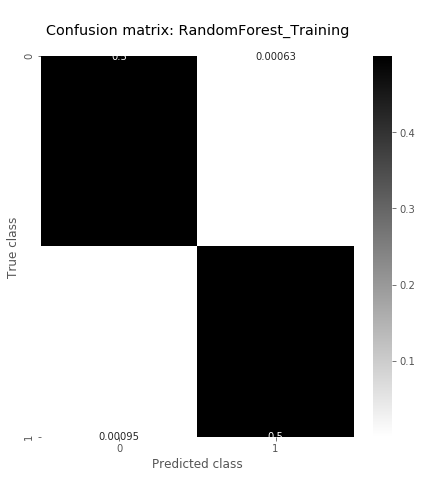

True Negatives:  1573  True Negatives %:  49.94
False Positives:  2  False Postitves %:  0.06
False Negatives:  3  Flase Negatives %:  0.1
True Positives:  1572  True Positives %:  49.9



Validation Dataset:
Accuracy:99.884 %
Precision:1.000
Recall:0.994
F1-score:0.997
Sensitivity:0.994
Specificity:1.000
Matthews correlation coefficient:0.997


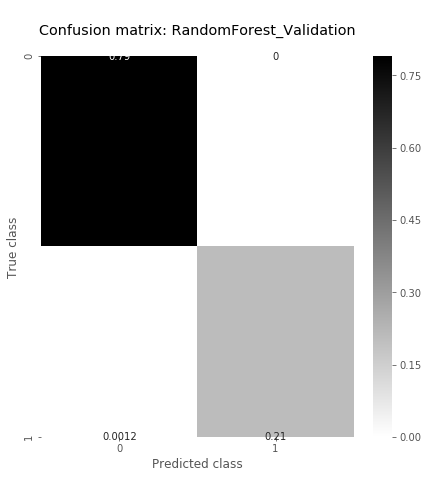

True Negatives:  1362  True Negatives %:  78.96
False Positives:  0  False Postitves %:  0.0
False Negatives:  2  Flase Negatives %:  0.12
True Positives:  361  True Positives %:  20.93


In [37]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier              #Import the Random Forest library 
from sklearn.metrics import confusion_matrix

conf_matrix_model_RF = ['RandomForest_Training','RandomForest_Validation']

rf_train = RandomForestClassifier()                 #Create Random Forest Classifier for training data
rf_valid = RandomForestClassifier()                  #Create Random Forest Classifier for validation data
rf_train.fit(X_train_tf, y_train)                                 #Fit classifier to our training sets
rf_valid.fit(X_valid_tf, y_valid)                                 #Fit classifier to our training sets

#Store the predicted output of the training feature set in variable 'y_train_pred'
y_train_pred = rf_train.predict(X_train_tf)
rf_train_cm = confusion_matrix(y_train,y_train_pred)              #Create confusion  matrix on training data

train_tn,train_fp,train_fn,train_tp = [(rf_train_cm[i,j]) for i in range(len(rf_train_cm)) for j in range(len(rf_train_cm))]
train_p = rf_train_cm[1,0] + rf_train_cm[1,1]
train_n = rf_train_cm[0,0] + rf_train_cm[0,1]


#Store the predicted output of the validation feature set in variable 'y_valid_pred'
y_valid_pred = rf_valid.predict(X_valid_tf)
rf_valid_cm = confusion_matrix(y_valid,y_valid_pred)              #Create confusion  matrix on validation data

valid_tn,valid_fp,valid_fn,valid_tp = [(rf_valid_cm[i,j]) for i in range(len(rf_valid_cm)) for j in range(len(rf_valid_cm))]
valid_p = rf_valid_cm[1,0] + rf_valid_cm[1,1]
valid_n = rf_valid_cm[0,0] + rf_valid_cm[0,1]

print('RANDOM FOREST MODEL-')
print("\n")
print('Training Dataset:')

rf_train_acc, rf_train_recall, rf_train_precision, rf_train_f1_measure, \
    rf_train_sensitivity, rf_train_specificity, rf_train_mcc = print_report(train_tn,train_fp,train_fn,train_tp,train_p,train_n)
cm_results(conf_matrix_model_RF[0], rf_train_cm, y_train, y_train_pred)

print("\n\n")
print('Validation Dataset:')
rf_valid_acc, rf_valid_recall, rf_valid_precision, rf_valid_f1_measure, \
    rf_valid_sensitivity, rf_valid_specificity, rf_valid_mcc = print_report(valid_tn,valid_fp,valid_fn,valid_tp,valid_p,valid_n)
cm_results(conf_matrix_model_RF[1], rf_valid_cm, y_valid, y_valid_pred)


### Gradient Boosting Model

Gradient Boosting MODEL-


Training Dataset:
Accuracy:99.238 %
Precision:0.995
Recall:0.990
F1-score:0.992
Sensitivity:0.990
Specificity:0.995
Matthews correlation coefficient:0.985


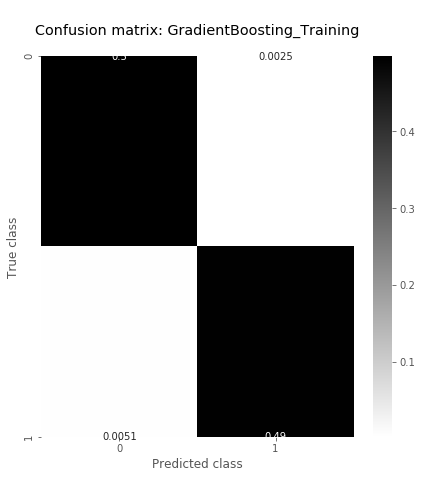

True Negatives:  1567  True Negatives %:  49.75
False Positives:  8  False Postitves %:  0.25
False Negatives:  16  Flase Negatives %:  0.51
True Positives:  1559  True Positives %:  49.49



Validation Dataset:
Accuracy:100.000 %
Precision:1.000
Recall:1.000
F1-score:1.000
Sensitivity:1.000
Specificity:1.000
Matthews correlation coefficient:1.000


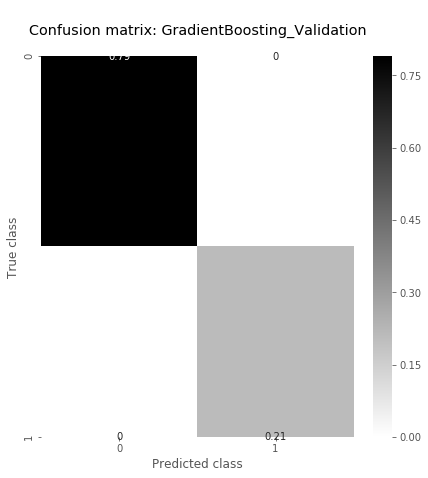

True Negatives:  1362  True Negatives %:  78.96
False Positives:  0  False Postitves %:  0.0
False Negatives:  0  Flase Negatives %:  0.0
True Positives:  363  True Positives %:  21.04


In [38]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import GradientBoostingClassifier             #Import the Gradient Booster library 
from sklearn.metrics import confusion_matrix


conf_matrix_model_GB = ['GradientBoosting_Training','GradientBoosting_Validation']

gb_train = GradientBoostingClassifier()                             #Create Gradient Booster Classifier for training data
gb_valid = GradientBoostingClassifier()                             #Create Gradient Booster Classifier for validation data
gb_train.fit(X_train_tf, y_train)                                   #Fit classifier to our training sets
gb_valid.fit(X_valid_tf, y_valid)                                   #Fit classifier to our training sets

#Store the predicted output of the training feature set in variable 'y_train_pred'
y_train_pred = gb_train.predict(X_train_tf)
gb_train_cm = confusion_matrix(y_train,y_train_pred)                #Create confusion  matrix on training data

train_tn,train_fp,train_fn,train_tp = [(gb_train_cm[i,j]) for i in range(len(gb_train_cm)) for j in range(len(gb_train_cm))]
train_p = gb_train_cm[1,0] + gb_train_cm[1,1]
train_n = gb_train_cm[0,0] + gb_train_cm[0,1]


#Store the predicted output of the validation feature set in variable 'y_valid_pred'
y_valid_pred = gb_valid.predict(X_valid_tf)
gb_valid_cm = confusion_matrix(y_valid,y_valid_pred)                #Create confusion  matrix on validation data

valid_tn,valid_fp,valid_fn,valid_tp = [(gb_valid_cm[i,j]) for i in range(len(gb_valid_cm)) for j in range(len(gb_valid_cm))]
valid_p = gb_valid_cm[1,0] + gb_valid_cm[1,1]
valid_n = gb_valid_cm[0,0] + gb_valid_cm[0,1]

print('Gradient Boosting MODEL-')
print("\n")
print('Training Dataset:')

gb_train_acc, gb_train_recall, gb_train_precision, gb_train_f1_measure, \
    gb_train_sensitivity, gb_train_specificity, gb_train_mcc = print_report(train_tn,train_fp,train_fn,train_tp,train_p,train_n)
cm_results(conf_matrix_model_GB[0], gb_train_cm, y_train, y_train_pred)

print("\n\n")
print('Validation Dataset:')
gb_valid_acc, gb_valid_recall, gb_valid_precision, gb_valid_f1_measure, \
    gb_valid_sensitivity, gb_valid_specificity, gb_valid_mcc = print_report(valid_tn,valid_fp,valid_fn,valid_tp,valid_p,valid_n)
cm_results(conf_matrix_model_GB[1], gb_valid_cm, y_valid, y_valid_pred)

### Decision Tree Model

DECISION TREE MODEL-


Training Dataset:
Accuracy:97.746 %
Precision:0.997
Recall:0.958
F1-score:0.977
Sensitivity:0.958
Specificity:0.997
Matthews correlation coefficient:0.956


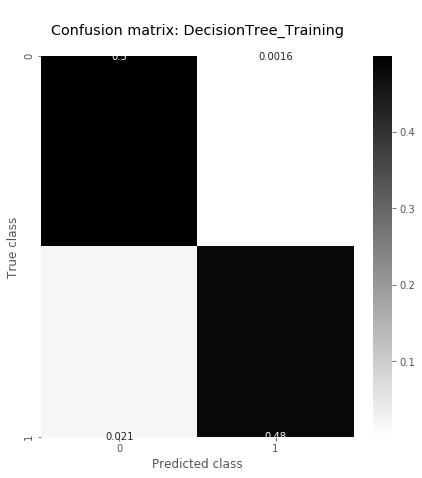

True Negatives:  1570  True Negatives %:  49.84
False Positives:  5  False Postitves %:  0.16
False Negatives:  66  Flase Negatives %:  2.1
True Positives:  1509  True Positives %:  47.9



Validation Dataset:
Accuracy:99.130 %
Precision:1.000
Recall:0.959
F1-score:0.979
Sensitivity:0.959
Specificity:1.000
Matthews correlation coefficient:0.974


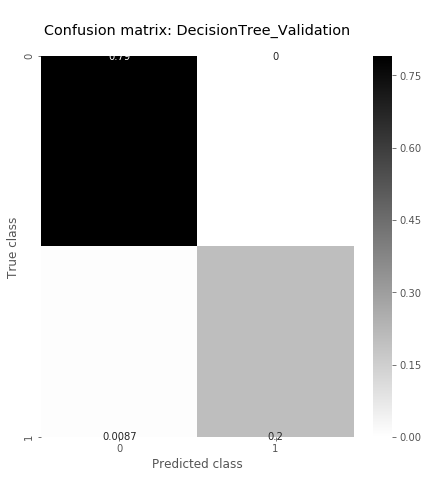

True Negatives:  1362  True Negatives %:  78.96
False Positives:  0  False Postitves %:  0.0
False Negatives:  15  Flase Negatives %:  0.87
True Positives:  348  True Positives %:  20.17


In [39]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier                                      #Import the DecisionTree library 
from sklearn.metrics import confusion_matrix


conf_matrix_model_DT= ['DecisionTree_Training','DecisionTree_Validation']

dt_train = DecisionTreeClassifier(max_depth = 10, random_state = 69)                 #Create DecisionTree Classifier for training data
dt_valid = DecisionTreeClassifier(max_depth = 10, random_state = 69)                 #Create DecisionTree Classifier for validation data
dt_train.fit(X_train_tf, y_train)                                                    #Fit classifier to our training sets
dt_valid.fit(X_valid_tf, y_valid)                                                    #Fit classifier to our training sets

#Store the predicted output of the training feature set in variable 'y_train_pred'
y_train_pred = dt_train.predict(X_train_tf)
dt_train_cm = confusion_matrix(y_train,y_train_pred)                                 #Create confusion  matrix on training data

train_tn,train_fp,train_fn,train_tp = [(dt_train_cm[i,j]) for i in range(len(dt_train_cm)) for j in range(len(dt_train_cm))]
train_p = dt_train_cm[1,0] + dt_train_cm[1,1]
train_n = dt_train_cm[0,0] + dt_train_cm[0,1]


#Store the predicted output of the validation feature set in variable 'y_valid_pred'
y_valid_pred = dt_valid.predict(X_valid_tf)
dt_valid_cm = confusion_matrix(y_valid,y_valid_pred)                                  #Create confusion  matrix on validation data

valid_tn,valid_fp,valid_fn,valid_tp = [(dt_valid_cm[i,j]) for i in range(len(dt_valid_cm)) for j in range(len(dt_valid_cm))]
valid_p = dt_valid_cm[1,0] + dt_valid_cm[1,1]
valid_n = dt_valid_cm[0,0] + dt_valid_cm[0,1]

print('DECISION TREE MODEL-')
print("\n")
print('Training Dataset:')
dt_train_acc, dt_train_recall, dt_train_precision, dt_train_f1_measure, \
    dt_train_sensitivity, dt_train_specificity, dt_train_mcc = print_report(train_tn,train_fp,train_fn,train_tp,train_p,train_n)
cm_results(conf_matrix_model_DT[0], dt_train_cm, y_train, y_train_pred)

print("\n\n")
print('Validation Dataset:')
dt_valid_acc, dt_valid_recall, dt_valid_precision, dt_valid_f1_measure, \
    dt_valid_sensitivity, dt_valid_specificity, dt_valid_mcc = print_report(valid_tn,valid_fp,valid_fn,valid_tp,valid_p,valid_n)
cm_results(conf_matrix_model_DT[1], dt_valid_cm, y_valid, y_valid_pred)

# Analyze Models

In [40]:
#Let us now create a dataframe which stores all the results of the model and we can compare the results of each model on the basis of every parameter

df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','NB','NB','RF','RF','GB','GB','DT','DT'],
                           'data set':['train','valid']*6,
                           'accuracy':[knn_train_acc,knn_valid_acc,lr_train_acc,lr_valid_acc,nb_train_acc,nb_valid_acc,rf_train_acc,rf_valid_acc,gb_train_acc,gb_valid_acc,dt_train_acc,dt_valid_acc],
                           'precision':[knn_train_precision,knn_valid_precision,lr_train_precision,lr_valid_precision,nb_train_precision,nb_valid_precision,rf_train_precision,rf_valid_precision,gb_train_precision,gb_valid_precision,dt_train_precision,dt_valid_precision],
                           'recall':[knn_train_recall,knn_valid_recall,lr_train_recall,lr_valid_recall,nb_train_recall,nb_valid_recall,rf_train_recall,rf_valid_recall,gb_train_recall,gb_valid_recall,dt_train_recall,dt_valid_recall],
                           'f1-score':[knn_train_f1_measure,knn_valid_f1_measure,lr_train_f1_measure,lr_valid_f1_measure,nb_train_f1_measure,nb_valid_f1_measure,rf_train_f1_measure,rf_valid_f1_measure,gb_train_f1_measure,gb_valid_f1_measure,dt_train_f1_measure,dt_valid_f1_measure],
                           'sensitivity':[knn_train_sensitivity,knn_valid_sensitivity,lr_train_sensitivity,lr_valid_sensitivity,nb_train_sensitivity,nb_valid_sensitivity,rf_train_sensitivity,rf_valid_sensitivity,gb_train_sensitivity,gb_valid_sensitivity,dt_train_sensitivity,dt_train_specificity],
                           'specificity':[knn_train_specificity,knn_valid_specificity,lr_train_specificity,lr_valid_specificity,nb_train_specificity,nb_valid_specificity,rf_train_specificity,rf_valid_specificity,gb_train_specificity,gb_valid_specificity,dt_train_specificity,dt_valid_specificity],
                           'mcc':[knn_train_mcc,knn_valid_mcc,lr_train_mcc,lr_valid_mcc,nb_train_mcc,nb_valid_mcc,rf_train_mcc,rf_valid_mcc,gb_train_mcc,gb_valid_mcc,dt_train_mcc,dt_valid_mcc]})

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

### Bar Graph

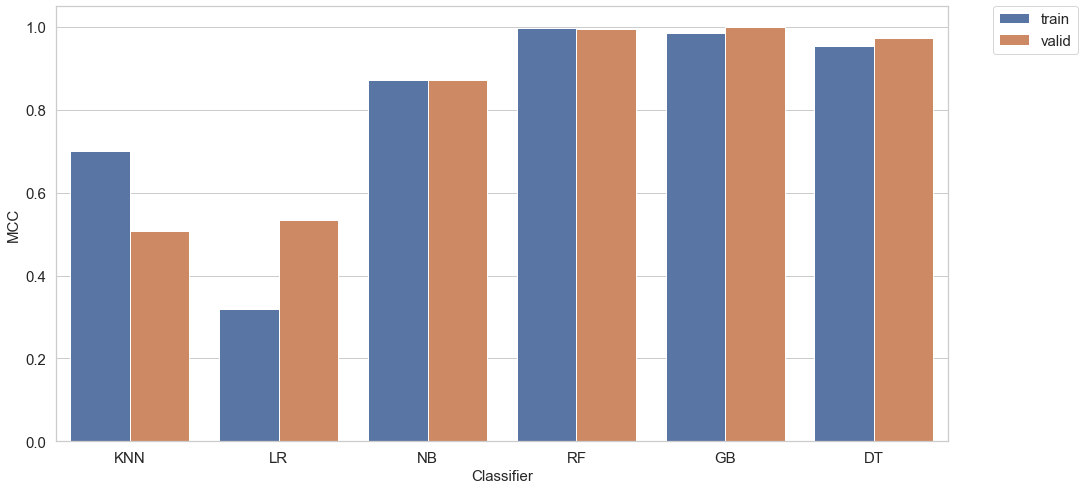

In [42]:
#Create a bar graph for training and validation sets of each classifier that compares 'MCC'

plt.figure(figsize=(16, 8))
ax = sns.barplot(x = 'classifier', y = 'mcc', hue = 'data set', data = df_results)
ax.set_xlabel('Classifier', fontsize = 15)
ax.set_ylabel('MCC', fontsize = 15)
ax.tick_params(labelsize = 15)

#Separate legend from graph
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., fontsize = 15)

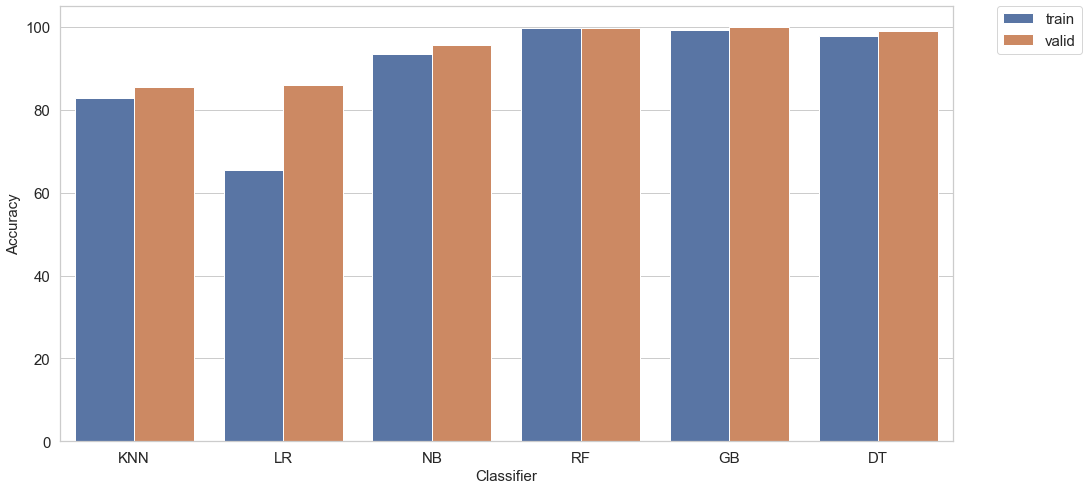

In [43]:
#Create a bar graph for training and validation sets of each classifier that compares 'Accuracy'

plt.figure(figsize=(16, 8))
ax = sns.barplot(x = 'classifier', y = 'accuracy', hue = 'data set', data = df_results)
ax.set_xlabel('Classifier', fontsize = 15)
ax.set_ylabel('Accuracy', fontsize = 15)
ax.tick_params(labelsize = 15)

#Separate legend from graph
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., fontsize = 15)

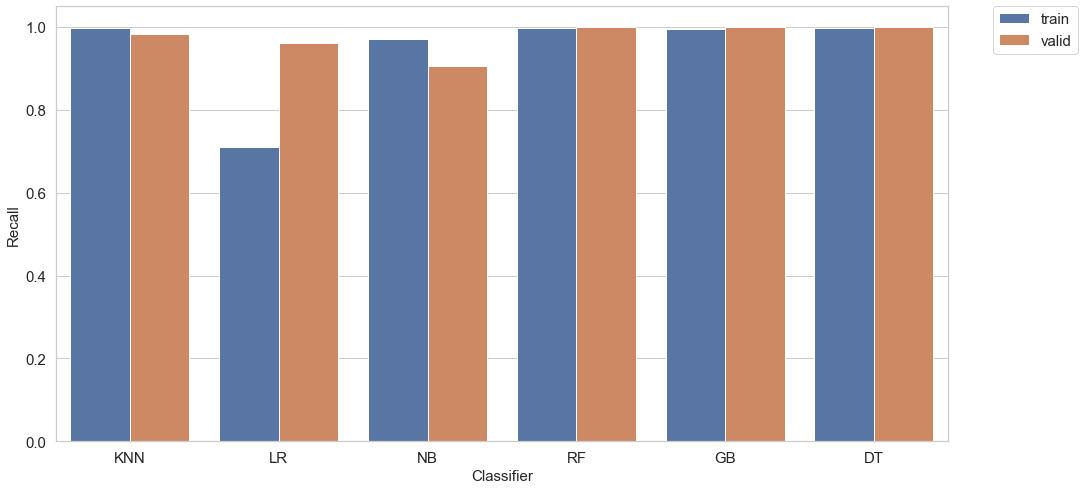

In [44]:
#Create a bar graph for training and validation sets of each classifier that compares 'Recall'

plt.figure(figsize=(16, 8))
ax = sns.barplot(x = 'classifier', y = 'recall', hue = 'data set', data = df_results)
ax.set_xlabel('Classifier', fontsize = 15)
ax.set_ylabel('Recall', fontsize = 15)
ax.tick_params(labelsize = 15)

#Separate legend from graph
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., fontsize = 15)

In [45]:
#Plot learning curves for the best performing model (ie GradientBoosting) and for DecsionTree model to compare the 2 models on basis of Accuracy.

import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
    
    title : string; Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression; None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional; Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional; Determines the cross-validation splitting strategy.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    
    plt.figure(figsize=(16, 8))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### Learning Curves

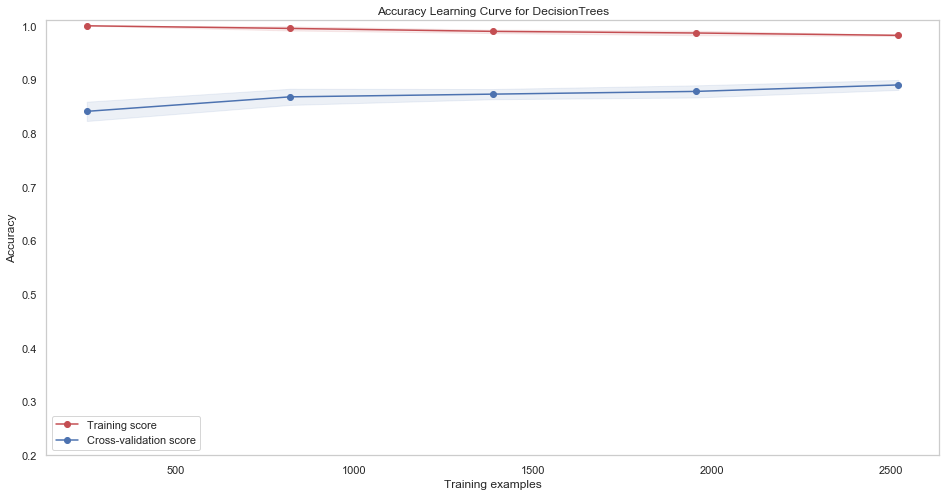

In [46]:
#Cross validation with 5 iterations to get smoother mean test and train
#Score curves, each time with 20% data randomly selected as a validation set.

from sklearn.tree import DecisionTreeClassifier

title = 'Accuracy Learning Curve for DecisionTrees'                                   
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = DecisionTreeClassifier(max_depth = 10, random_state = 69)                                     
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)


plt.show()

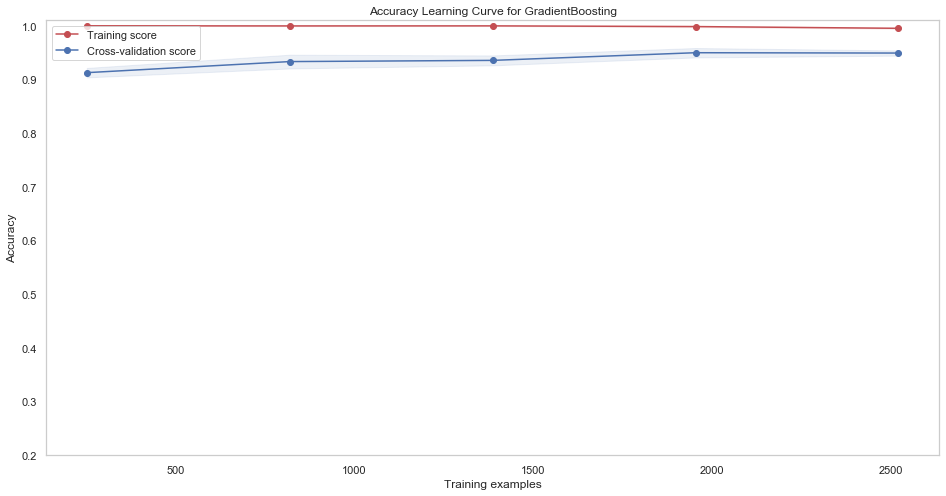

In [47]:
#Cross validation with 5 iterations to get smoother mean test and train
#Score curves, each time with 20% data randomly selected as a validation set.

from sklearn.tree import DecisionTreeClassifier

title = 'Accuracy Learning Curve for GradientBoosting'                                   
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = GradientBoostingClassifier()                                     
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)


plt.show()

####  We see that Gradient Boosting is our best model, followed by Random Forest and Decision Tree. We will now tune Decision Tree Model and see if we can improve its performance.

# Hyperparameter Tuning

In [48]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import RandomizedSearchCV 
  
dt = DecisionTreeRegressor(random_state=42)

from pprint import pprint
# Look at parameters used by our current tree
print('Parameters currently in use:\n')
pprint(dt.get_params())

Parameters currently in use:

{'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 42,
 'splitter': 'best'}


### Validation Curves

Text(0, 0.5, 'Accuracy')

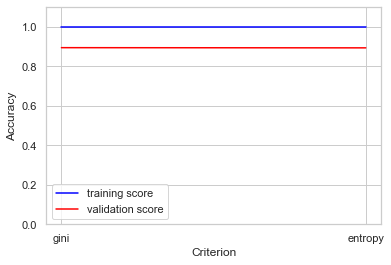

In [49]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

param_range = ['gini','entropy']
train_score, test_score = validation_curve(
                                DecisionTreeClassifier(),
                                X = X_train_tf, y = y_train, 
                                param_name = 'criterion', 
                                param_range = param_range, cv = 3)


plt.plot(param_range, np.median(train_score, 1), color='blue', label='training score')
plt.plot(param_range, np.median(test_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1.1)
plt.xlabel('Criterion')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

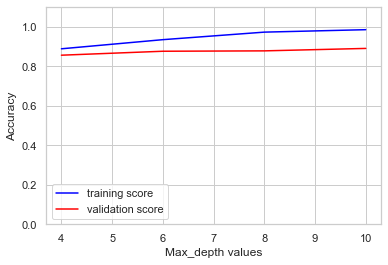

In [50]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

param_range = [4,6,8,10]
train_score, test_score = validation_curve(
                                DecisionTreeClassifier(),
                                X = X_train_tf, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = param_range, cv = 3)


plt.plot(param_range, np.median(train_score, 1), color='blue', label='training score')
plt.plot(param_range, np.median(test_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1.1)
plt.xlabel('Max_depth values')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

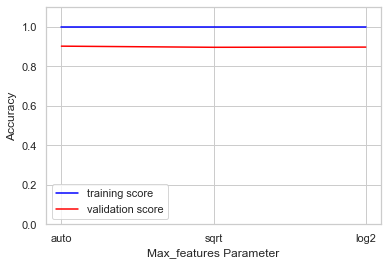

In [51]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

param_range = ['auto','sqrt','log2']
train_score, test_score = validation_curve(
                                DecisionTreeClassifier(),
                                X = X_train_tf, y = y_train, 
                                param_name = 'max_features', 
                                param_range = param_range, cv = 3)


plt.plot(param_range, np.median(train_score, 1), color='blue', label='training score')
plt.plot(param_range, np.median(test_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1.1)
plt.xlabel('Max_features Parameter')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

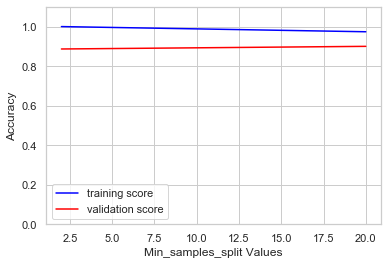

In [52]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

param_range = [2,20]
train_score, test_score = validation_curve(
                                DecisionTreeClassifier(),
                                X = X_train_tf, y = y_train, 
                                param_name = 'min_samples_split', 
                                param_range = param_range, cv = 3)


plt.plot(param_range, np.median(train_score, 1), color='blue', label='training score')
plt.plot(param_range, np.median(test_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1.1)
plt.xlabel('Min_samples_split Values')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

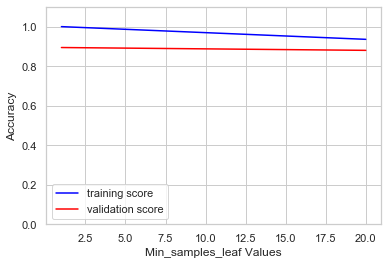

In [53]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

param_range = [1,20]
train_score, test_score = validation_curve(
                                DecisionTreeClassifier(),
                                X = X_train_tf, y = y_train, 
                                param_name = 'min_samples_leaf', 
                                param_range = param_range, cv = 3)


plt.plot(param_range, np.median(train_score, 1), color='blue', label='training score')
plt.plot(param_range, np.median(test_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1.1)
plt.xlabel('Min_samples_leaf Values')
plt.ylabel('Accuracy')

### RandomSearch

In [54]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import RandomizedSearchCV 
  
# Creating the hyperparameter grid  
param_dist = {"max_depth": [1,15], 
              "max_features": [1,15], 
              'min_samples_split': [2,40], 
              "min_samples_leaf": [1,20],
              'splitter': ['best','random'],
              "criterion": ["gini", "entropy"]} 
  
# Instantiating Decision Tree classifier 
tree = DecisionTreeClassifier() 
  
# Instantiating RandomizedSearchCV object 
tree_cv = RandomizedSearchCV(tree, param_dist, n_iter=40, cv = 5, scoring="accuracy", random_state=42, n_jobs=-1, return_train_score=True) 
  
tree_cv.fit(X_train_tf, y_train) 
  
# Print the tuned parameters and score 
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_)) 
print("Best score is {}".format(tree_cv.best_score_)) 

Tuned Decision Tree Parameters: {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 15, 'max_depth': 15, 'criterion': 'entropy'}
Best score is 0.9012698412698412


In [55]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import RandomizedSearchCV 
  
# Creating the hyperparameter grid  
param_dist = {"max_depth": [1,15], 
              "max_features": [1,15], 
              'min_samples_split': [2,40], 
              "min_samples_leaf": [1,20],
              'splitter': ['best','random'],
              "criterion": ["gini", "entropy"]} 
  
# Instantiating Decision Tree classifier 
tree = DecisionTreeClassifier() 
  
# Instantiating RandomizedSearchCV object 
tree_cv = RandomizedSearchCV(tree, param_dist, n_iter=40, cv = 5, scoring="accuracy", random_state=42, n_jobs=-1, return_train_score=True) 
  
tree_cv.fit(X_valid_tf, y_valid) 
  
# Print the tuned parameters and score 
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_)) 
print("Best score is {}".format(tree_cv.best_score_)) 

Tuned Decision Tree Parameters: {'splitter': 'best', 'min_samples_split': 40, 'min_samples_leaf': 1, 'max_features': 15, 'max_depth': 15, 'criterion': 'gini'}
Best score is 0.9310144927536231


In [56]:
print(dt_train_acc,dt_valid_acc)

97.74603174603175 99.1304347826087


In [57]:
print(dt_train_mcc,dt_valid_mcc)

0.955637644176434 0.9737733688610626


In [58]:
def print_report2(tn,fp,fn,tp,p,n):
    import math
    accuracy = ((tp + tn)/(tp + tn + fp + fn))*100
    mcc = ((tp*tn)-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return accuracy, mcc

In [59]:
y_train_pred2 = tree_cv.predict(X_train_tf)
tree_cv_cm_train = confusion_matrix(y_train,y_train_pred2)                                 #Create confusion  matrix on training data

train_tn,train_fp,train_fn,train_tp = [(tree_cv_cm_train[i,j]) for i in range(len(tree_cv_cm_train)) for j in range(len(tree_cv_cm_train))]
train_p = tree_cv_cm_train[1,0] + tree_cv_cm_train[1,1]
train_n = tree_cv_cm_train[0,0] + tree_cv_cm_train[0,1]

acc,mcc = print_report2(train_tn,train_fp,train_fn,train_tp,train_p,train_n)
print(acc,mcc)

89.65079365079364 0.7946841180940306


In [60]:
y_valid_pred2 = tree_cv.predict(X_valid_tf)
tree_cv_cm_valid = confusion_matrix(y_valid,y_valid_pred2)                                 #Create confusion  matrix on training data

valid_tn,valid_fp,valid_fn,valid_tp = [(tree_cv_cm_valid[i,j]) for i in range(len(tree_cv_cm_valid)) for j in range(len(tree_cv_cm_valid))]
valid_p = tree_cv_cm_valid[1,0] + tree_cv_cm_valid[1,1]
valid_n = tree_cv_cm_valid[0,0] + tree_cv_cm_valid[0,1]

acc,mcc = print_report2(valid_tn,valid_fp,valid_fn,valid_tp,valid_p,valid_n)
print(acc,mcc)

95.76811594202898 0.8777251831952186


#### We see that after hypertuning the Decision Tree Model, the accuracy and value of Matthew's Correlation Coefficient goes down for the testing data. We will now proceed to use our best model (ie GradientBoosting) on the test data.

# Model Testing & Evaluation 

In [61]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import GradientBoostingClassifier                     #Import the Gradient Booster library 
from sklearn.metrics import confusion_matrix


best_model_train = GradientBoostingClassifier()                             #Create Gradient Booster Classifier for training data
best_model_valid = GradientBoostingClassifier()                             #Create Gradient Booster Classifier for validation data
best_model_train.fit(X_train_tf, y_train)                                   #Fit classifier to our training sets
best_model_valid.fit(X_valid_tf, y_valid)                                   #Fit classifier to our training sets

#Store the predicted output of the training feature set in variable 'y_train_pred'
y_train_pred = best_model_train.predict(X_train_tf)
best_model_train_cm = confusion_matrix(y_train,y_train_pred)                #Create confusion  matrix on training data

train_tn,train_fp,train_fn,train_tp = [(best_model_train_cm[i,j]) for i in range(len(best_model_train_cm)) for j in range(len(best_model_train_cm))]
train_p = best_model_train_cm[1,0] + best_model_train_cm[1,1]
train_n = best_model_train_cm[0,0] + best_model_train_cm[0,1]


#Store the predicted output of the validation feature set in variable 'y_valid_pred'
y_valid_pred = best_model_valid.predict(X_valid_tf)
best_model_valid_cm = confusion_matrix(y_valid,y_valid_pred)                #Create confusion  matrix on validation data

valid_tn,valid_fp,valid_fn,valid_tp = [(best_model_valid_cm[i,j]) for i in range(len(best_model_valid_cm)) for j in range(len(best_model_valid_cm))]
valid_p = best_model_valid_cm[1,0] + best_model_valid_cm[1,1]
valid_n = best_model_valid_cm[0,0] + best_model_valid_cm[0,1]

print('BEST MODEL-')
print("\n")
print('Training Dataset:')
gb_train_acc, gb_train_recall, gb_train_precision, gb_train_f1_measure, \
    gb_train_sensitivity, gb_train_specificity, gb_train_mcc = print_report(train_tn,train_fp,train_fn,train_tp,train_p,train_n)

print("\n\n")
print('Validation Dataset:')
gb_valid_acc, gb_valid_recall, gb_valid_precision, gb_valid_f1_measure, \
    gb_valid_sensitivity, gb_valid_specificity, gb_valid_mcc = print_report(valid_tn,valid_fp,valid_fn,valid_tp,valid_p,valid_n)

BEST MODEL-


Training Dataset:
Accuracy:99.238 %
Precision:0.995
Recall:0.990
F1-score:0.992
Sensitivity:0.990
Specificity:0.995
Matthews correlation coefficient:0.985



Validation Dataset:
Accuracy:100.000 %
Precision:1.000
Recall:1.000
F1-score:1.000
Sensitivity:1.000
Specificity:1.000
Matthews correlation coefficient:1.000


Testing Dataset:
Accuracy:99.942 %
Precision:1.000
Recall:0.997
F1-score:0.999
Sensitivity:0.997
Specificity:1.000
Matthews correlation coefficient:0.998


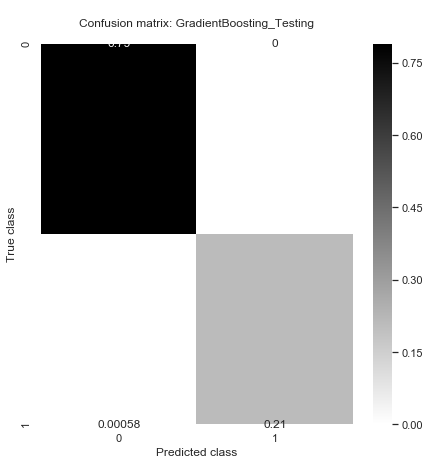

True Negatives:  1362  True Negatives %:  78.91
False Positives:  0  False Postitves %:  0.0
False Negatives:  1  Flase Negatives %:  0.06
True Positives:  363  True Positives %:  21.03


In [62]:
gb_test = GradientBoostingClassifier()                           #Create Gradient Booster Classifier for testing data
gb_test.fit(X_test_tf, y_test)                                   #Fit classifier to our training sets

#Store the predicted output of the training feature set in variable 'y_test_pred'
y_test_pred = gb_test.predict(X_test_tf)
gb_test_cm = confusion_matrix(y_test,y_test_pred)                #Create confusion  matrix on training data

test_tn,test_fp,test_fn,test_tp = [(gb_test_cm[i,j]) for i in range(len(gb_test_cm)) for j in range(len(gb_test_cm))]
test_p = gb_test_cm[1,0] + gb_test_cm[1,1]
test_n = gb_test_cm[0,0] + gb_test_cm[0,1]

print('Testing Dataset:')

gb_test_acc, gb_test_recall, gb_test_precision, gb_test_f1_measure, \
    gb_test_sensitivity, gb_test_specificity, gb_test_mcc = print_report(test_tn,test_fp,test_fn,test_tp,test_p,test_n)
cm_results('GradientBoosting_Testing', gb_test_cm, y_test, y_test_pred)


### ROC_Curve


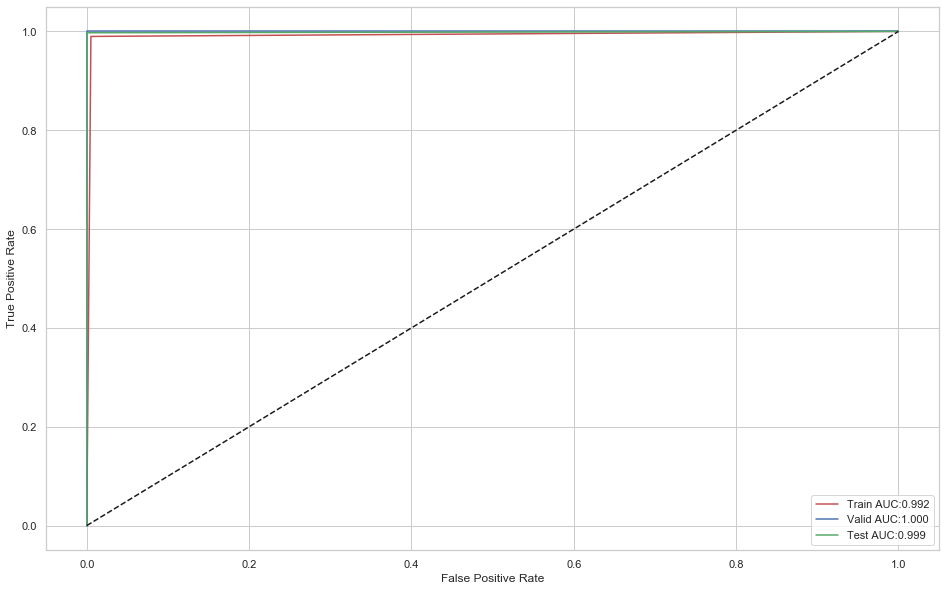

In [63]:
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
auc_train = roc_auc_score(y_train, y_train_pred)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_pred)
auc_valid = roc_auc_score(y_valid, y_valid_pred)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

plt.figure(figsize=(16,10))
plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()